In [1]:
import os
import sys
import time
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import keras.backend as K
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from keras.optimizers import SGD, Adam
from keras.models import Sequential
from keras.regularizers import l1_l2
from sklearn.metrics import accuracy_score
from collections import OrderedDict, Counter
from tensorflow.python.ops import gen_array_ops
from keras.layers import Dense, Dropout, Flatten
from names import Names as n

In [28]:
from scipy.stats import gaussian_kde
from descartes import PolygonPatch
import alphashape
from sklearn.cluster import KMeans

In [3]:
from pathlib import Path
from harness.test_harness_class import TestHarness
from harness.th_model_instances.hamed_models.random_forest_classification import random_forest_classification
from harness.th_model_instances.hamed_models.weighted_logistic import weighted_logistic_classifier

In [4]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 10000)
pd.set_option('display.max_colwidth', None)
matplotlib.use("tkagg")
%matplotlib inline
warnings.filterwarnings('ignore')

In [5]:
col_idx = OrderedDict([(n.label, 0), ("inducer_concentration", 1), ("timepoint", 2), ("percent_live", 3)])

# Read in Data and Prepare Variables

In [6]:
duke_v2_with_strateos_80 = pd.read_csv("experiment_data/processed/duke_v2_with_strateos_80.csv")


In [7]:
duke_v2_with_strateos_80

,inducer_concentration,timepoint,stain,FSC-A,SSC-A,YL1-A,FSC-H,SSC-H,YL1-H,FSC-W,SSC-W,YL1-W,percent_live,source
0,0.0,0.0,1.0,6.020600,6.020600,4.900930,5.764440,5.411980,2.940520,3.00988,3.00988,0.0,79.495714,duke_v2
1,0.0,0.0,1.0,5.389450,4.592750,2.597700,5.371090,4.594220,2.414970,1.96379,1.87506,0.0,79.495714,duke_v2
2,0.0,0.0,1.0,5.450140,4.883100,2.403120,5.415370,4.848330,2.233000,1.94448,1.89763,0.0,79.495714,duke_v2
3,0.0,0.0,1.0,5.644360,5.118360,2.866290,5.583750,5.063450,2.638490,1.95424,1.94448,0.0,79.495714,duke_v2
4,0.0,0.0,1.0,5.258560,4.683070,1.806180,5.259830,4.681420,2.181840,1.90309,1.86332,0.0,79.495714,duke_v2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1464061,80.0,6.0,1.0,4.121822,2.887617,0.000000,3.756712,2.685742,1.732394,0.00000,0.00000,0.0,0.000000,strateos
1464062,80.0,6.0,1.0,4.981198,0.000000,0.000000,3.822037,2.838849,2.025306,0.00000,0.00000,0.0,0.000000,strateos
1464063,80.0,6.0,1.0,5.295772,0.000000,0.000000,3.789792,2.615950,2.086360,0.00000,0.00000,0.0,0.000000,strateos
1464064,80.0,6.0,1.0,5.471633,0.000000,0.000000,3.768120,2.840106,2.127105,0.00000,0.00000,0.0,0.000000,strateos


In [8]:
duke_stained = duke_v2_with_strateos_80.loc[duke_v2_with_strateos_80["stain"] == 1]
duke_unstained = duke_v2_with_strateos_80.loc[duke_v2_with_strateos_80["stain"] == 0]

In [9]:
features_unstained = n.morph_cols
features_stained_duke = n.morph_cols + ["YL1-A", "YL1-H", "YL1-W"]

In [10]:
print(features_unstained)
print(features_stained_duke)

['FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W']
['FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W', 'YL1-A', 'YL1-H', 'YL1-W']


In [11]:
duke_stained

,inducer_concentration,timepoint,stain,FSC-A,SSC-A,YL1-A,FSC-H,SSC-H,YL1-H,FSC-W,SSC-W,YL1-W,percent_live,source
0,0.0,0.0,1.0,6.020600,6.020600,4.900930,5.764440,5.411980,2.940520,3.00988,3.00988,0.0,79.495714,duke_v2
1,0.0,0.0,1.0,5.389450,4.592750,2.597700,5.371090,4.594220,2.414970,1.96379,1.87506,0.0,79.495714,duke_v2
2,0.0,0.0,1.0,5.450140,4.883100,2.403120,5.415370,4.848330,2.233000,1.94448,1.89763,0.0,79.495714,duke_v2
3,0.0,0.0,1.0,5.644360,5.118360,2.866290,5.583750,5.063450,2.638490,1.95424,1.94448,0.0,79.495714,duke_v2
4,0.0,0.0,1.0,5.258560,4.683070,1.806180,5.259830,4.681420,2.181840,1.90309,1.86332,0.0,79.495714,duke_v2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1464061,80.0,6.0,1.0,4.121822,2.887617,0.000000,3.756712,2.685742,1.732394,0.00000,0.00000,0.0,0.000000,strateos
1464062,80.0,6.0,1.0,4.981198,0.000000,0.000000,3.822037,2.838849,2.025306,0.00000,0.00000,0.0,0.000000,strateos
1464063,80.0,6.0,1.0,5.295772,0.000000,0.000000,3.789792,2.615950,2.086360,0.00000,0.00000,0.0,0.000000,strateos
1464064,80.0,6.0,1.0,5.471633,0.000000,0.000000,3.768120,2.840106,2.127105,0.00000,0.00000,0.0,0.000000,strateos


# Model Functions

In [12]:
def training_progress(fitted_model, metrics, num_plots, loss_name, plot_val=None):
    '''
    A function for plotting the model history by showing the metric and loss throughout training
    '''
    plt.subplot(1, num_plots, 2)
    plt.plot(fitted_model.history['loss'], label='train loss')
    if plot_val is not None:
        plt.plot(fitted_model.history['val_loss'], label='val loss')
    plt.title('Loss ({})'.format(loss_name))
#     plt.legend()

    for i, metric in enumerate(metrics):
        subplot_number = i + 3
        plt.subplot(1, num_plots, subplot_number)
        plt.plot(fitted_model.history[metric], label=str(metric))
        if plot_val is not None:
            plt.plot(fitted_model.history[f'val_{metric}'], label=f'val_{metric}')
        plt.title(str(metric))
#         plt.legend()

    plt.show()


def plot_model_result(model, fitted_model, metrics, X, loss_name, plot_val=None):
    '''
    plot the foe_probabilities of a model
    plot the training history
    show training accuracy
    '''
    num_plots = len(metrics) + 2
    probas = model.predict_proba(X)
    plt.figure(figsize=(15, 5))
    plt.subplot(1, num_plots, 1)
    plt.hist(probas)
    plt.xlabel('predict_proba')
    training_progress(fitted_model, metrics, num_plots, loss_name, plot_val)

In [13]:
def bin_cross(label_conds_cfus, y_pred):
    y_pred = K.flatten(y_pred)
    y_true = label_conds_cfus[:, col_idx[n.label]]
    final_loss = tf.losses.binary_crossentropy(y_true=y_true, y_pred=y_pred)
    return final_loss

def cfu_loss(label_conds_cfus, y_pred):
    cfu_percent_live = label_conds_cfus[:, col_idx["percent_live"]]
    cfu_percent_live = cfu_percent_live / 100.0
    condition_indices = [col_idx["inducer_concentration"], col_idx["timepoint"]]
    conditions = tf.gather(label_conds_cfus, condition_indices, axis=1)
    y_pred = K.flatten(y_pred)
    y_pred = tf.sigmoid((y_pred - 0.5) * 100)
    uniques, idx, count = gen_array_ops.unique_with_counts_v2(conditions, [0])
    num_unique = tf.size(count)
    pred_percents = tf.math.unsorted_segment_mean(data=y_pred, segment_ids=idx, num_segments=num_unique)
    cfu_percents = tf.math.unsorted_segment_mean(data=cfu_percent_live, segment_ids=idx, num_segments=num_unique)
    diff = tf.math.subtract(pred_percents, cfu_percents)
    abs_diff = K.abs(diff)
    abs_diff_mean = tf.math.reduce_mean(abs_diff)
    return abs_diff_mean

def joint_loss_wrapper(cfu_loss_weight):
    
    def joint_loss(label_conds_cfus, y_pred):
        loss_bin_cross = bin_cross(label_conds_cfus=label_conds_cfus, y_pred=y_pred)
        loss_cfu = cfu_loss(label_conds_cfus=label_conds_cfus, y_pred=y_pred)
        return loss_bin_cross + cfu_loss_weight*loss_cfu
    
    return joint_loss

In [14]:
def booster_model_v2(input_shape=None, loss=joint_loss_wrapper(2), metrics=None, lr=0.1):
    if metrics is None:
        metrics = [loss]
    
    model = Sequential()
    model.add(Dense(units=32, activation="relu", input_shape=(input_shape,)))
    model.add(Dropout(0.1))
    model.add(Dense(units=16, activation="relu"))
    model.add(Dropout(0.1))
    model.add(Dense(units=8, activation="relu"))
    model.add(Dropout(0.1))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(loss=loss, optimizer=Adam(lr=lr),
                  metrics=metrics, run_eagerly=True)
    return model

In [15]:
def run_model(model_function, lr, loss, metrics, X, Y, epochs, batch_size, verbose, shuffle, plot_type="scatter"):
    # reset model each time
    tf.compat.v1.reset_default_graph
    tf.keras.backend.clear_session()
    
    # create model
    model = model_function(input_shape=len(X.columns), loss=loss, metrics=metrics, lr=lr)
#     print(model.summary())
    
    # fit model and predict
    start_time = time.time()
    fitted_model = model.fit(X, Y, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle=shuffle)
    predict_proba = model.predict(X)
    class_predictions = np.ndarray.flatten(predict_proba > 0.5).astype("int32")
    
    # print metrics
    training_accuracy = accuracy_score(y_true=Y[n.label], y_pred=class_predictions)
    print("\nModel Boosting took {} seconds".format(time.time() - start_time))
    print("Training Accuracy = {}%".format(round(100 * training_accuracy, 2)))
    print(Counter(class_predictions))
    
    # plot probabilities and losses
    plot_model_result(model=model, fitted_model=fitted_model,
                      metrics=[x.__name__ for x in metrics],
                      X=X, loss_name=loss.__name__, plot_val=None)
    
    # print summary of predictions vs. cfus
    preds_and_labels = Y.copy()
    preds_and_labels[n.label] = preds_and_labels[n.label] * 100
    preds_and_labels["nn_preds"] = class_predictions * 100
    preds_and_labels.rename(columns={"percent_live":"cfu_percent_live"}, inplace=True)
    groupby_means = preds_and_labels.groupby([n.inducer_concentration, n.timepoint]).mean()
    # print(groupby_means)
    
    condition_results = groupby_means.reset_index()
        
    # plot percent live over conditions
#     plot_percent_live_over_conditions(condition_results, plot_type)

    return condition_results, preds_and_labels

# Plotting Functions

In [87]:
def plot_percent_live_over_conditions(condition_results, plot_type="scatter", 
                                      color_by=n.inducer_concentration, fig_height=10,
                                      title=""):
    percent_live_df = condition_results
    
    plt.figure(figsize=(15, fig_height))
    sns.set(style="ticks", font_scale=2.0, rc={"lines.linewidth": 3.0})
    color_levels = list(percent_live_df[color_by].unique())
    color_levels.sort()
    num_colors = len(color_levels)
    palette = dict(zip(color_levels, sns.color_palette("bright", num_colors)))
    
    if plot_type == "line":
#         labels = sns.lineplot(x=percent_live_df[n.timepoint], y=percent_live_df[n.label],
#                       hue=percent_live_df[color_by], 
#                       palette=palette, legend=False, zorder=1, style=True, dashes=[(2,2)])

        preds = sns.lineplot(x=percent_live_df[n.timepoint], y=percent_live_df["nn_preds"],
                          hue=percent_live_df[color_by], 
                          palette=palette, legend="full", zorder=1)
        
        cfus = sns.scatterplot(x=percent_live_df[n.timepoint], y=percent_live_df["cfu_percent_live"],
                   hue=percent_live_df[color_by], 
                   palette=palette, legend=False, zorder=1, s=250, marker="o")

    elif plot_type == "scatter":
        labels = sns.scatterplot(x=percent_live_df[n.timepoint]-0.14, y=percent_live_df[n.label],
                                 hue=percent_live_df[color_by], 
                                 palette=palette, legend="full", zorder=1, s=250, marker="s")

        preds = sns.scatterplot(x=percent_live_df[n.timepoint], y=percent_live_df["nn_preds"],
                                hue=percent_live_df[color_by], 
                                palette=palette, legend=False, zorder=1, s=250, marker="^")
        
        cfus = sns.scatterplot(x=percent_live_df[n.timepoint]+0.14, y=percent_live_df["cfu_percent_live"],
                           hue=percent_live_df[color_by], 
                           palette=palette, legend=False, zorder=1, s=250, marker="o")
        plt.title("Square = Label Percent Live\nTriangle = Predicted Percent Live\nCircle = CFU Percent Live")

    
    elif plot_type == "mixed":
        labels = sns.scatterplot(x=percent_live_df[n.timepoint]-0.01, y=percent_live_df[n.label],
                                 hue=percent_live_df[color_by], 
                                 palette=palette, legend=False, zorder=1, s=250, marker="s")

        preds = sns.lineplot(x=percent_live_df[n.timepoint], y=percent_live_df["nn_preds"],
#                                 hue=percent_live_df[color_by], 
                                palette=palette, legend=False, zorder=1)
        
        cfus = sns.scatterplot(x=percent_live_df[n.timepoint]+0.01, y=percent_live_df["cfu_percent_live"],
                           hue=percent_live_df[color_by], 
                           palette=palette, legend=False, zorder=1, s=250, marker="o")
        plt.title(title, fontweight="bold")
        plt.xlabel("Exposure Time")
        plt.ylabel("Percent Live")



    # visual settings
    plt.xlim(0, 6.5)
    plt.ylim(-5, 105)
#     legend = plt.legend(bbox_to_anchor=(1.01, 0.9), loc=2, borderaxespad=0.,
#                         handlelength=4, markerscale=1.8)
#     legend.get_frame().set_edgecolor('black')

In [17]:
def plot_per_cond(condition_results):
    for conc in condition_results[n.inducer_concentration].unique():
        temp = condition_results.loc[condition_results[n.inducer_concentration] == conc]
        plot_percent_live_over_conditions(temp, plot_type="mixed", color_by=n.timepoint, fig_height=5,
                                          title="Ethanol Concentration = {}".format(conc))

In [18]:
def plot_prob_changes(concat, y_max):
    zero_to_zero = concat.loc[concat["change_type"]=="Remained Dead", "label_probs"]
    one_to_one = concat.loc[concat["change_type"]=="Remained Live", "label_probs"]
    zero_to_one = concat.loc[concat["change_type"]=="Changed from Dead to Live", "label_probs"]
    one_to_zero = concat.loc[concat["change_type"]=="Changed from Live to Dead", "label_probs"]

    plt.figure(figsize=(10,10))
    sns.distplot(zero_to_zero, bins=100, label="Remained Dead")
    sns.distplot(zero_to_one, bins=100, label="Changed from Dead to Live")
    sns.distplot(one_to_zero, bins=100, label="Changed from Live to Dead")
    sns.distplot(one_to_one, bins=100, label="Remained Live")

    plt.legend()
    plt.ylim(0, y_max)
    legend = plt.legend(bbox_to_anchor=(1.01, 0.9), loc=2, borderaxespad=0.,
                        handlelength=4, markerscale=1.8)
    legend.get_frame().set_edgecolor('black')
    
    
def get_all_run_info(df, X, pl, append_df_cols=None):
    if append_df_cols is not None:
        X = pd.concat([X, df[append_df_cols]], axis=1)
    concat = pd.concat([X, pl], axis=1)
    concat["nn_preds"] = concat["nn_preds"]/100
    concat[n.label] = concat[n.label]/100
    concat["changed"] = ~(concat["label"] == concat["nn_preds"])
    concat["change_type"] = "this_should_be_gone"
    concat.loc[(concat["label"] == 0) & (concat["nn_preds"] == 0), "change_type"] = "Remained Dead"
    concat.loc[(concat["label"] == 1) & (concat["nn_preds"] == 1), "change_type"] = "Remained Live"
    concat.loc[(concat["label"] == 0) & (concat["nn_preds"] == 1), "change_type"] = "Changed from Dead to Live"
    concat.loc[(concat["label"] == 1) & (concat["nn_preds"] == 0), "change_type"] = "Changed from Live to Dead"
    concat['nn_percent_live'] = concat.groupby([n.inducer_concentration, 
                                                n.timepoint])["nn_preds"].transform('mean') * 100
    concat["label_probs"] = df["label_probs"]
    
    return concat

# Functions to create Labels for each DataFrame via Random Forest Models

In [19]:
def generate_rf_labels_from_conditions(data_df, features,
                                       live_conditions=None, dead_conditions=None):
    df = data_df.copy()
    df["arbitrary_index"] = df.index
    
    if live_conditions is None:
        live_conditions = [{n.inducer_concentration: 0.0, n.timepoint: 6.0}]
    if dead_conditions is None:
        dead_conditions = [{n.inducer_concentration: 20.0, n.timepoint: 6.0},
                           {n.inducer_concentration: 80.0, n.timepoint: 6.0}]
    print("Conditions designated as Live: {}".format(live_conditions))
    print("Conditions designated as Dead: {}".format(dead_conditions))
    print()
    
    
    # Label points according to live_conditions and dead_conditions
    # first obtain indexes of the rows that correspond to live_conditions and dead_conditions
    live_indexes = []
    dead_indexes = []
    for lc in live_conditions:
        live_indexes += list(df.loc[(df[list(lc)] == pd.Series(lc)).all(axis=1), n.index])
    for dc in dead_conditions:
        dead_indexes += list(df.loc[(df[list(dc)] == pd.Series(dc)).all(axis=1), n.index])
    labeled_indexes = live_indexes + dead_indexes

    # TODO: check if this should call .copy() or not
    labeled_df = df[df[n.index].isin(labeled_indexes)]
    labeled_df.loc[labeled_df[n.index].isin(live_indexes), n.label] = 1
    labeled_df.loc[labeled_df[n.index].isin(dead_indexes), n.label] = 0    
    
    th = TestHarness(output_location=Path("__file__"))
    th.run_custom(function_that_returns_TH_model=random_forest_classification,
                  dict_of_function_parameters={},
                  training_data=labeled_df,
                  testing_data=labeled_df,
                  description="asdf",
                  target_cols=n.label,
                  feature_cols_to_use=features,
                  index_cols=["arbitrary_index"],
                  normalize=False,
                  feature_cols_to_normalize=features,
                  feature_extraction=False,
                  predict_untested_data=df)
    
    
    run_id = th.list_of_this_instance_run_ids[-1]
    labeled_df = pd.read_csv("__file__/test_harness_results/runs/run_{}/predicted_data.csv".format(run_id))
    
    df = pd.merge(df, labeled_df, on="arbitrary_index", how="left")
    df.rename(columns={"label_predictions":n.label, "label_prob_predictions":"label_probs"}, inplace=True)
    
    X = df[features]
    Y = df[col_idx.keys()]
    
    return df, X, Y

# Generate RF Labels for Stained data but only using Morph Features

In [55]:
df_duke_stained_morph, \
X_duke_stained_morph, \
Y_duke_stained_morph = generate_rf_labels_from_conditions(duke_stained,
                                                          features_unstained,
                                                live_conditions=[{'inducer_concentration': 0.0, 'timepoint': 0.0},
                                                                 {'inducer_concentration': 0.0, 'timepoint': 0.5},
                                                                 {'inducer_concentration': 0.0, 'timepoint': 3.0},
                                                                 {'inducer_concentration': 0.0, 'timepoint': 6.0}],
                                                dead_conditions=None
                                                         )

Conditions designated as Live: [{'inducer_concentration': 0.0, 'timepoint': 0.0}, {'inducer_concentration': 0.0, 'timepoint': 0.5}, {'inducer_concentration': 0.0, 'timepoint': 3.0}, {'inducer_concentration': 0.0, 'timepoint': 6.0}]
Conditions designated as Dead: [{'inducer_concentration': 20.0, 'timepoint': 6.0}, {'inducer_concentration': 80.0, 'timepoint': 6.0}]


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 20:53:03
Starting Classification training...
Training time was: 33.58 seconds
Testing time was: 4.41 seconds
Prediction time of untested data was: 20.946261882781982
Run finished at 20:54:07. Total run time = 64.14 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^




# All Plots/Models use Stained data, but models only use morph features

**Replacing CFU percent_live values for 0% ethanol at time 0.5 and 1.0 with 100% before feeding into the model**

In [56]:
Y_duke_stained_morph.loc[(Y_duke_stained_morph[n.inducer_concentration] == 0.0) & 
                             (Y_duke_stained_morph[n.timepoint].isin([0.5, 1.0, 5.0])), n.percent_live] = 100.0
# Y_duke_stained_morph


Model Boosting took 307.7639751434326 seconds
Training Accuracy = 75.65%
Counter({0: 397319, 1: 350794})


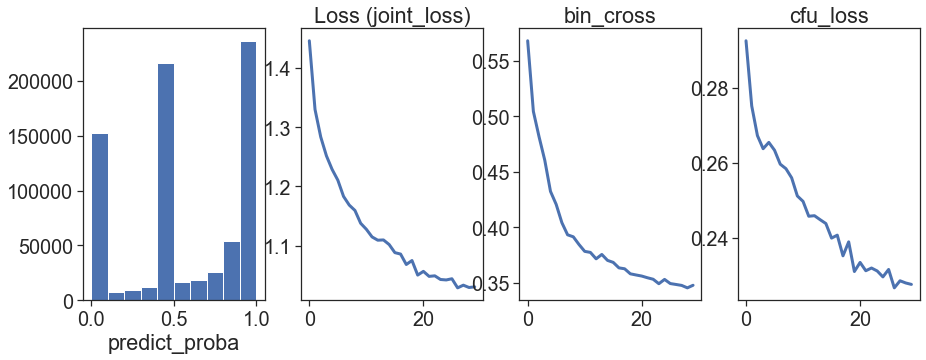

In [57]:
cr_duke_stained_morph, \
pl_duke_stained_morph = run_model(model_function=booster_model_v2, lr=0.001,
                                      loss = joint_loss_wrapper(3), metrics = [bin_cross, cfu_loss],
                                      X = X_duke_stained_morph, Y = Y_duke_stained_morph, 
                                      epochs = 30, batch_size = 2048,
                                      verbose = False, shuffle = True, plot_type="line")

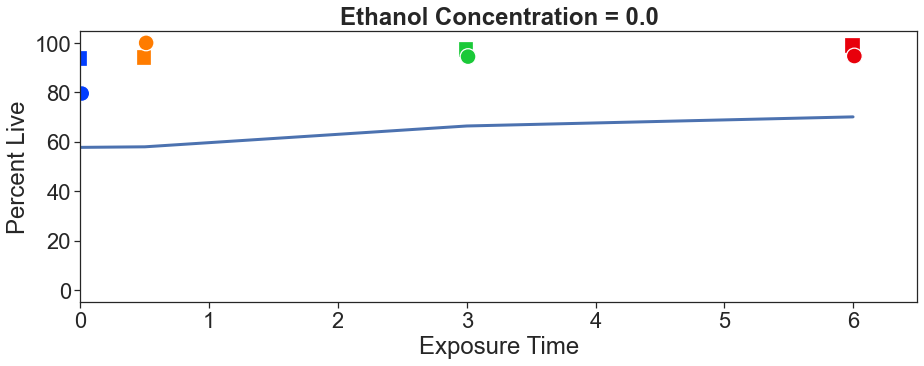

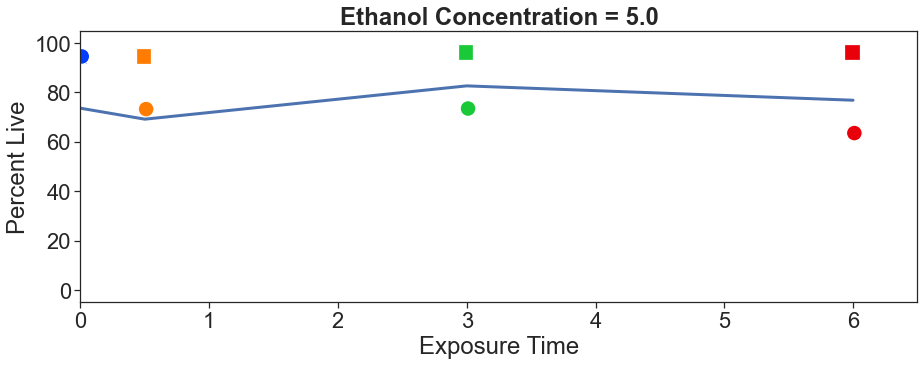

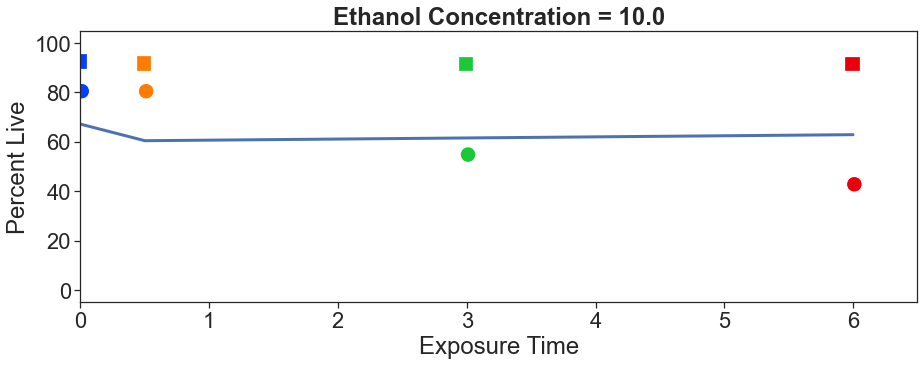

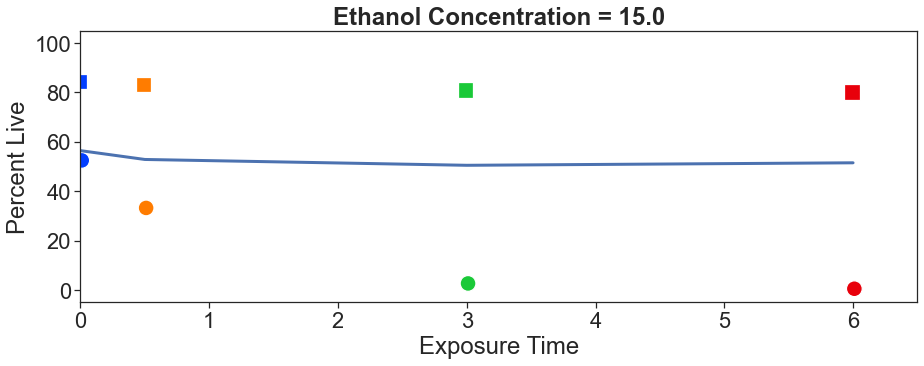

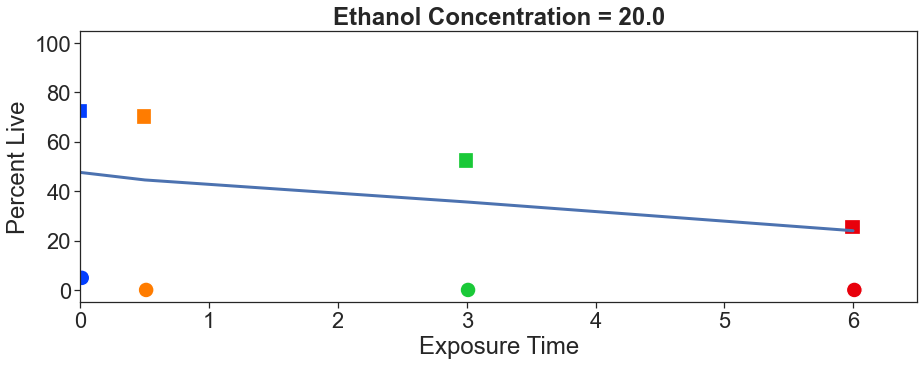

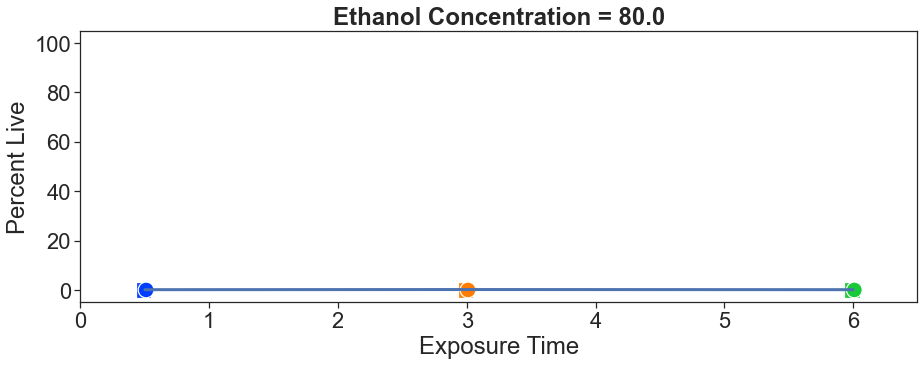

In [88]:
plot_per_cond(cr_duke_stained_morph)

In [59]:
info_duke_stained_morph = get_all_run_info(df_duke_stained_morph, 
                                               X_duke_stained_morph,
                                               pl_duke_stained_morph,
                                               append_df_cols=["YL1-A", "YL1-H", "YL1-W"])

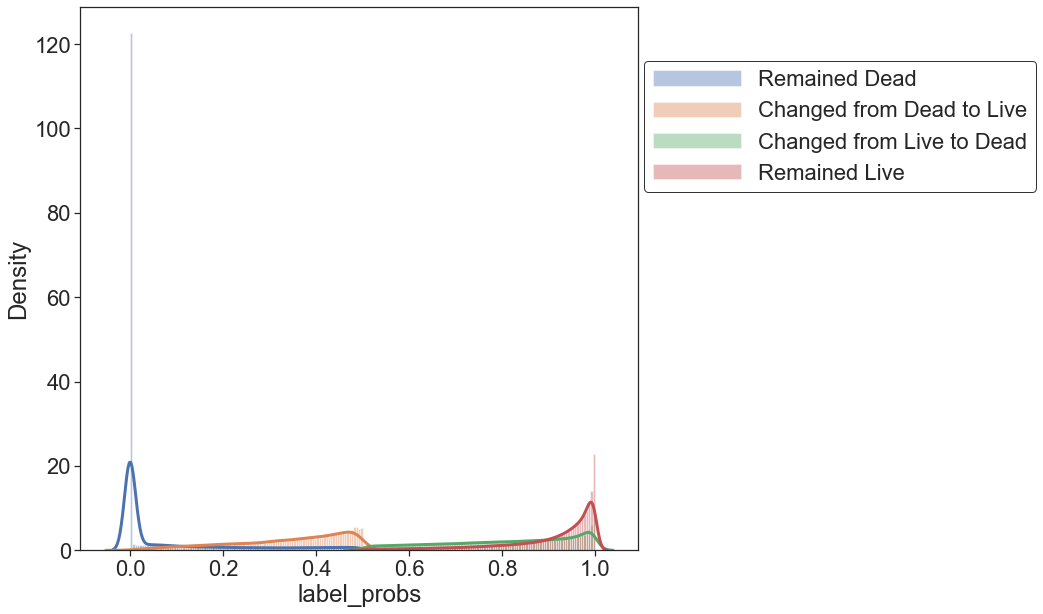

In [60]:
plot_prob_changes(info_duke_stained_morph, None)

# Calculate KDEs to get point density

In [61]:
def get_point_density_values(x, y):
    xy = np.vstack([x,y])
    return gaussian_kde(xy)(xy)


def get_conc_df_with_kde_values(conc):
    if conc == "all":
        # Getting KDE values for all the data takes a longgggg time, so going to take a sample:
        conc_df = info_duke_stained_morph.sample(frac=0.05, random_state=5)
    else:
        conc_df = info_duke_stained_morph.loc[info_duke_stained_morph[n.inducer_concentration] == conc]
    
    # create unlogged features
    for f in features_stained_duke:
        conc_df["log_{}".format(f)] = conc_df[f]
        conc_df[f] = conc_df[f].pow(10)
        
    # calculate point densities for (SSC-A, FSC-A) and (YL1-H, FSC-A)
    conc_df["kde_S_F"] = get_point_density_values(x=conc_df["FSC-A"], y=conc_df["SSC-A"])
    conc_df["kde_R_F"] = get_point_density_values(x=conc_df["YL1-H"], y=conc_df["SSC-A"])
    conc_df["kde_log_S_F"] = get_point_density_values(x=conc_df["log_FSC-A"], y=conc_df["log_SSC-A"])
    conc_df["kde_log_R_F"] = get_point_density_values(x=conc_df["log_YL1-H"], y=conc_df["log_SSC-A"])
    
    return conc_df

In [62]:
# conc_df_0 = get_conc_df_with_kde_values(0)

In [63]:
# conc_df_10 = get_conc_df_with_kde_values(10)

In [64]:
# conc_df_15 = get_conc_df_with_kde_values(15)

In [65]:
# conc_df_20 = get_conc_df_with_kde_values(20)

In [66]:
# conc_df_80 = get_conc_df_with_kde_values(80)

In [67]:
conc_df_all = get_conc_df_with_kde_values("all")

# Scatter + KDE Plots

In [68]:
def kde_scatter(conc_df, logged=False, subset_ratio=0.5, 
                log_kde=False, n_bins=None, cmap="Spectral_r", 
                pred_col=None, pred_display_type="scatter_density",
                line_params=([2.4, 3.05], [4, 5.75])):
    dot_size = 1
    lines_color = "cyan"
    
    conc_df = conc_df.copy()
    
    fig = plt.figure(figsize=(20, 9))
    num_plot_cols = 2 
    ax1 = plt.subplot(1, num_plot_cols, 1)
    ax3 = plt.subplot(1, num_plot_cols, num_plot_cols)
    
    if logged:
        ssc = "log_SSC-A"
        rl1 = "log_YL1-H"
        fsc = "log_FSC-A"
        kde_sf = "kde_log_S_F"
        kde_rf = "kde_log_R_F"
    else:
        ssc = "SSC-A"
        rl1 = "YL1-H"
        fsc = "FSC-A"
        kde_sf = "kde_S_F"
        kde_rf = "kde_R_F"
        
    # Sort the points by density, so that the densest points appear on top
    conc_df = conc_df.sort_values(by=kde_sf)
    
    # log kde values if specified
    if log_kde is True:
        conc_df[kde_sf] = np.log10(conc_df[kde_sf])
        conc_df[kde_rf] = np.log10(conc_df[kde_rf])
    
    # switch to plotting bins if n_bins is specified
    if n_bins is not None:
        conc_df[kde_sf] = pd.qcut(conc_df[kde_sf], n_bins, labels=False)
        conc_df[kde_rf] = pd.qcut(conc_df[kde_rf], n_bins, labels=False)

    # First plot:
    ax1.scatter(conc_df[ssc], conc_df[fsc], c=conc_df[kde_sf], s=dot_size, cmap=cmap)
    ax1.set_xlabel(ssc)
    ax1.set_ylabel(fsc)
  
    # Get subset of data based on percentage specified by subset_ratio (tail works because we sorted earlier)
    subset_df = conc_df.tail(int(len(conc_df)*subset_ratio))
    
    # Second plot: overlay alpha_shape of the subset we got
    # first doing a KMeans with 2 clusters to get an alpha shape around each ellipse
    subset_df["kmeans"] = KMeans(n_clusters=2, random_state=5).fit(subset_df[[ssc, fsc]]).labels_   
    subset_boundary_1 = alphashape.alphashape(list(zip(subset_df.loc[subset_df["kmeans"] == 0, ssc], 
                                                       subset_df.loc[subset_df["kmeans"] == 0, fsc])), 0)
    subset_boundary_2 = alphashape.alphashape(list(zip(subset_df.loc[subset_df["kmeans"] == 1, ssc], 
                                                       subset_df.loc[subset_df["kmeans"] == 1, fsc])), 0)
#     ax1.add_patch(PolygonPatch(subset_boundary_1, alpha=1.0, ec=lines_color, fc="none", lw=5))
    ax1.add_patch(PolygonPatch(subset_boundary_2, alpha=1.0, ec=lines_color, fc="none", lw=5))

    # Third plot:
    subset_no_debris = subset_df.loc[subset_df["kmeans"] == 1]
    ax3.scatter(subset_no_debris[rl1], subset_no_debris[fsc], 
                c=get_point_density_values(x=subset_no_debris[rl1], y=subset_no_debris[fsc]), 
                s=dot_size, cmap=cmap)
    ax3.set_xlabel(rl1)
    ax3.set_ylabel(fsc)
    ax3.set_ylim(ax1.get_ylim())
    ax3.set_xlim(right=5)
    # Overlay boundary line (eyeballing it like they do in SOA):
    ax3.plot(line_params[0], line_params[1], c=lines_color)
    
    ax1.set_title("Traditional Method: Visual Selection of Events", fontweight="bold")
    ax3.set_title("Traditional Method: Manual Line Splits Selection", fontweight="bold")
        
    if pred_col is not None:
        if pred_display_type == "scatter_density":
            fig = plt.figure(figsize=(20, 20))
            ax4 = plt.subplot(2, 2, 1)
            ax5 = plt.subplot(2, 2, 2)
            ax6 = plt.subplot(2, 2, 3)
            ax7 = plt.subplot(2, 2, 4)
            
            ax4.scatter(conc_df.loc[conc_df[pred_col] == 1, ssc],
                        conc_df.loc[conc_df[pred_col] == 1, fsc],
                        c=get_point_density_values(x=conc_df.loc[conc_df[pred_col] == 1, ssc],
                                                   y=conc_df.loc[conc_df[pred_col] == 1, fsc]),
                        s=dot_size, cmap=cmap)
            ax5.scatter(subset_df.loc[subset_df[pred_col] == 1, rl1],
                        subset_df.loc[subset_df[pred_col] == 1, fsc],
                        c=get_point_density_values(x=subset_df.loc[subset_df[pred_col] == 1, rl1],
                                                   y=subset_df.loc[subset_df[pred_col] == 1, fsc]),
                        s=dot_size, cmap=cmap)
            ax6.scatter(conc_df.loc[conc_df[pred_col] == 0, ssc],
                        conc_df.loc[conc_df[pred_col] == 0, fsc],
                        c=get_point_density_values(x=conc_df.loc[conc_df[pred_col] == 0, ssc],
                                                   y=conc_df.loc[conc_df[pred_col] == 0, fsc]),
                        s=dot_size, cmap=cmap)
            ax7.scatter(subset_df.loc[subset_df[pred_col] == 0, rl1],
                        subset_df.loc[subset_df[pred_col] == 0, fsc],
                        c=get_point_density_values(x=subset_df.loc[subset_df[pred_col] == 0, rl1],
                                                   y=subset_df.loc[subset_df[pred_col] == 0, fsc]),
                        s=dot_size, cmap=cmap)
            ax5.plot(line_params[0], line_params[1], c=lines_color)
            ax7.plot(line_params[0], line_params[1], c=lines_color)
            
            ax4.set_title("AutoGater: Predicted Healthy Cells", fontweight="bold")
            ax5.set_title("AutoGater: Predicted Healthy Cells", fontweight="bold")
            ax6.set_title("AutoGater: Predicted Dead, Dying, or Debris", fontweight="bold")
            ax7.set_title("AutoGater: Predicted Dead, Dying, or Debris", fontweight="bold")
            
            ax4.set_xlim(ax1.get_xlim())
            ax5.set_xlim(ax3.get_xlim())
            ax6.set_xlim(ax1.get_xlim())
            ax7.set_xlim(ax3.get_xlim())
            ax4.set_xlabel(ssc)
            ax5.set_xlabel(rl1)
            ax6.set_xlabel(ssc)
            ax7.set_xlabel(rl1)
            
            ax4.set_ylim(ax1.get_ylim())
            ax5.set_ylim(ax1.get_ylim())
            ax6.set_ylim(ax1.get_ylim())
            ax7.set_ylim(ax1.get_ylim())
            ax4.set_ylabel(fsc)
            ax5.set_ylabel(fsc)
            ax6.set_ylabel(fsc)
            ax7.set_ylabel(fsc)

        elif pred_display_type == "alpha_shape":
            live = list(zip(conc_df.loc[conc_df[pred_col] == 1, ssc], 
                            conc_df.loc[conc_df[pred_col] == 1, fsc]))
            dead = list(zip(conc_df.loc[conc_df[pred_col] == 0, ssc], 
                            conc_df.loc[conc_df[pred_col] == 0, fsc]))
            live[:] = [x for x in live if x != (0,0)]
            dead[:] = [x for x in dead if x != (0,0)]
            live_shape = alphashape.alphashape(live, 0)
            dead_shape = alphashape.alphashape(dead, 0)
            ax1.add_patch(PolygonPatch(live_shape, alpha=1.0, ec="cyan", fc="none", lw=5))
            ax1.add_patch(PolygonPatch(dead_shape, alpha=1.0, ec="hotpink", fc="none", lw=5))

            live = list(zip(subset_df.loc[subset_df[pred_col] == 1, rl1], 
                            subset_df.loc[subset_df[pred_col] == 1, fsc]))
            dead = list(zip(subset_df.loc[subset_df[pred_col] == 0, rl1], 
                            subset_df.loc[subset_df[pred_col] == 0, fsc]))
            live[:] = [x for x in live if x != (0,0)]
            dead[:] = [x for x in dead if x != (0,0)]
            live_shape = alphashape.alphashape(live, 0)
            dead_shape = alphashape.alphashape(dead, 0)
            ax3.add_patch(PolygonPatch(live_shape, alpha=1.0, ec="cyan", fc="none", lw=5))
            ax3.add_patch(PolygonPatch(dead_shape, alpha=1.0, ec="hotpink", fc="none", lw=5))
        else:
            raise ValueError("pred_display_type must equal 'scatter_density' or 'alpha_shape'"
                             "when pred_col is not None.")
    plt.show()
    
    return conc_df, subset_df

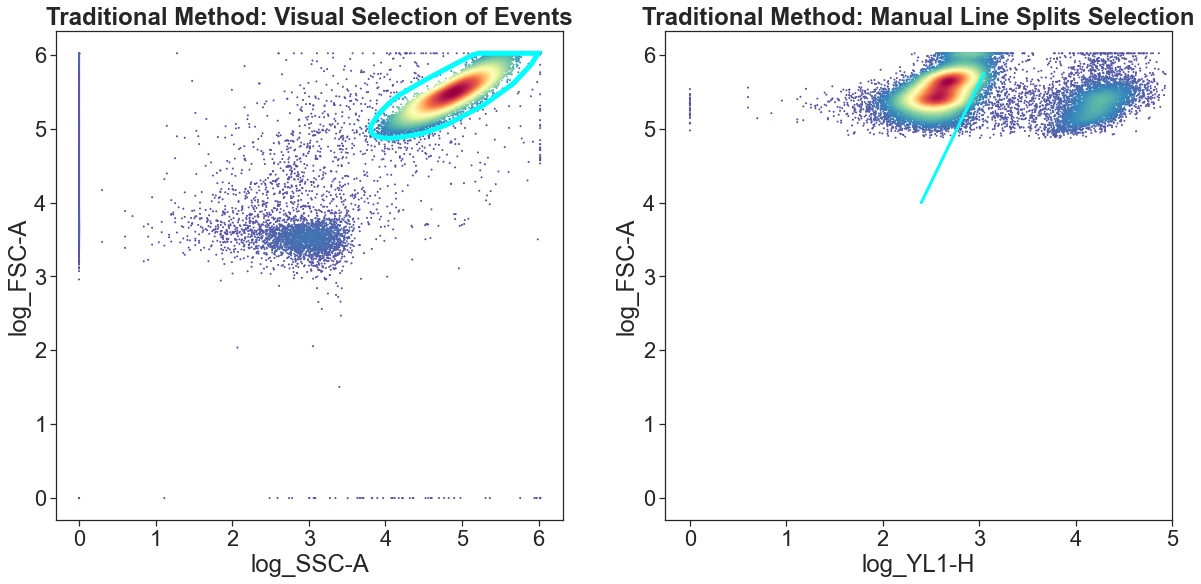

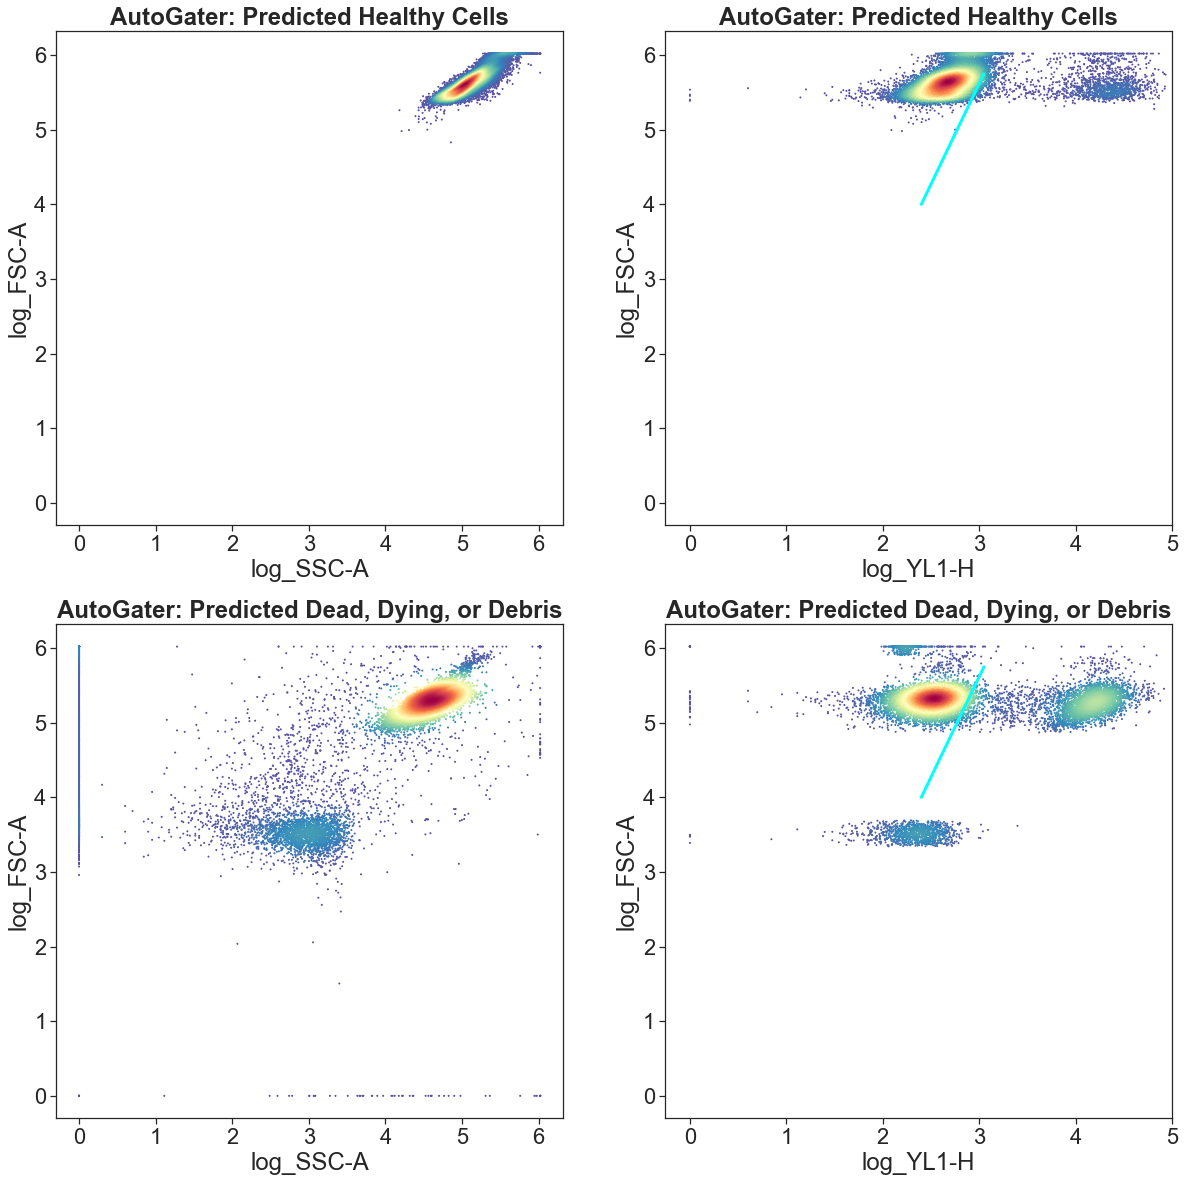

In [69]:
kde_df, kde_df_sub = kde_scatter(conc_df_all, logged=True, subset_ratio=0.85, cmap="Spectral_r",
                     pred_col="nn_preds", pred_display_type="scatter_density", 
                     line_params=([2.4, 3.05], [4, 5.75]))

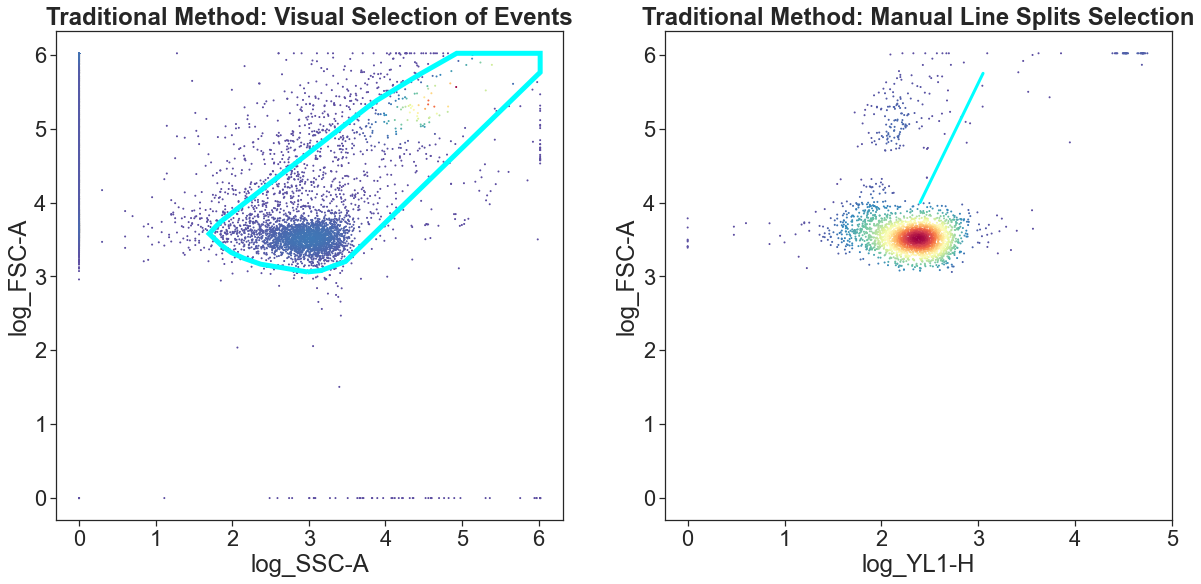

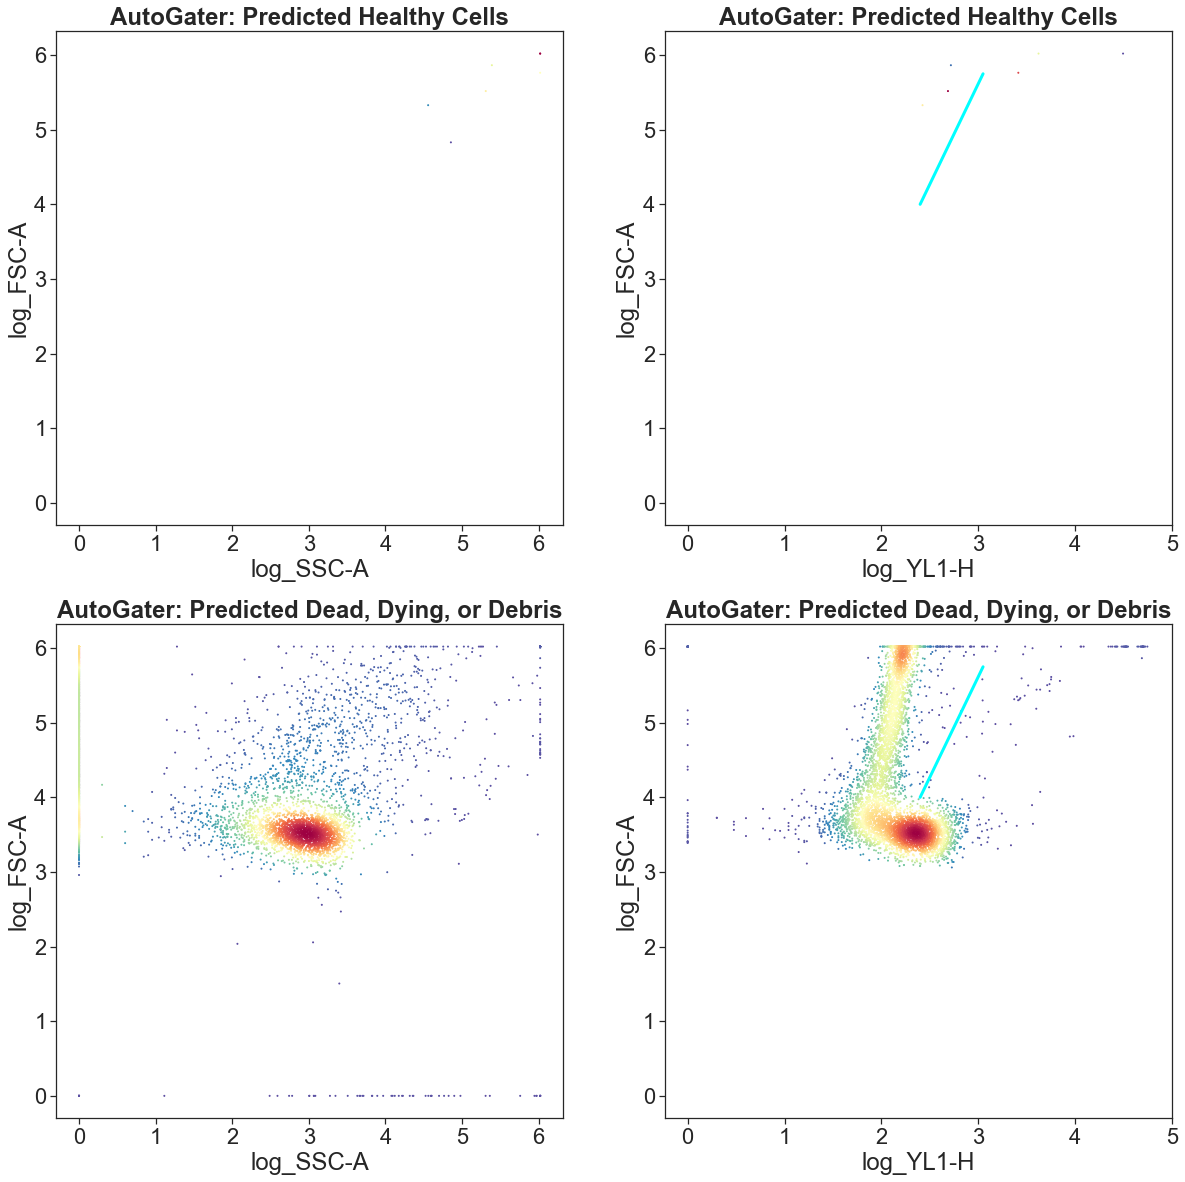

In [90]:
_, _ = kde_scatter(conc_df_all.loc[conc_df_all[n.inducer_concentration]==80.0], logged=True, 
                   subset_ratio=0.85, cmap="Spectral_r",
                   pred_col="nn_preds", pred_display_type="scatter_density", 
                   line_params=([2.4, 3.05], [4, 5.75]))

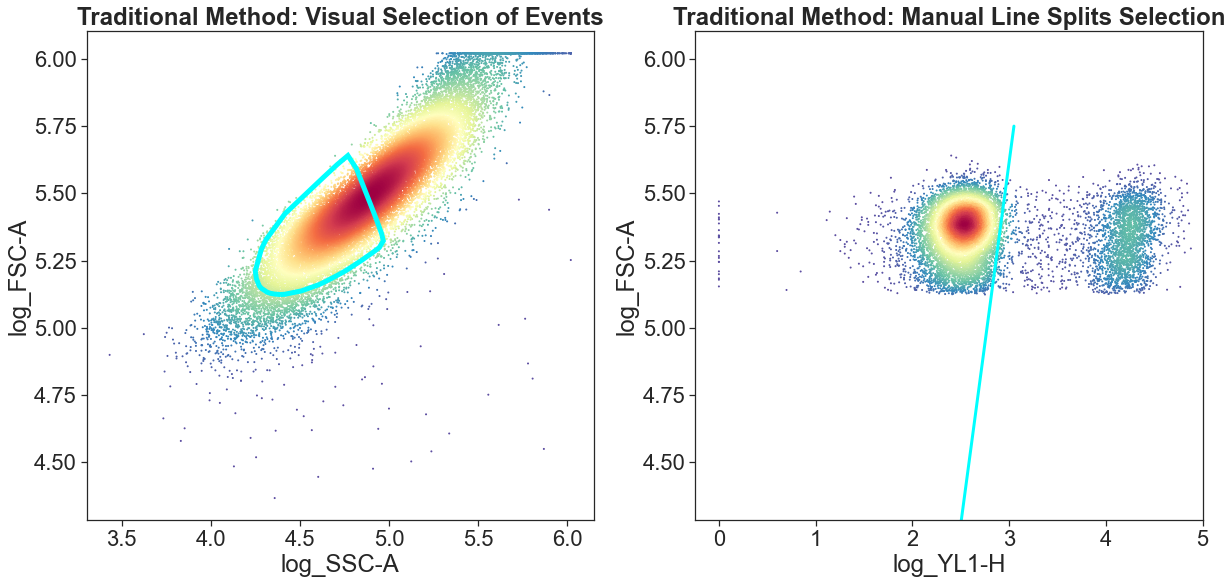

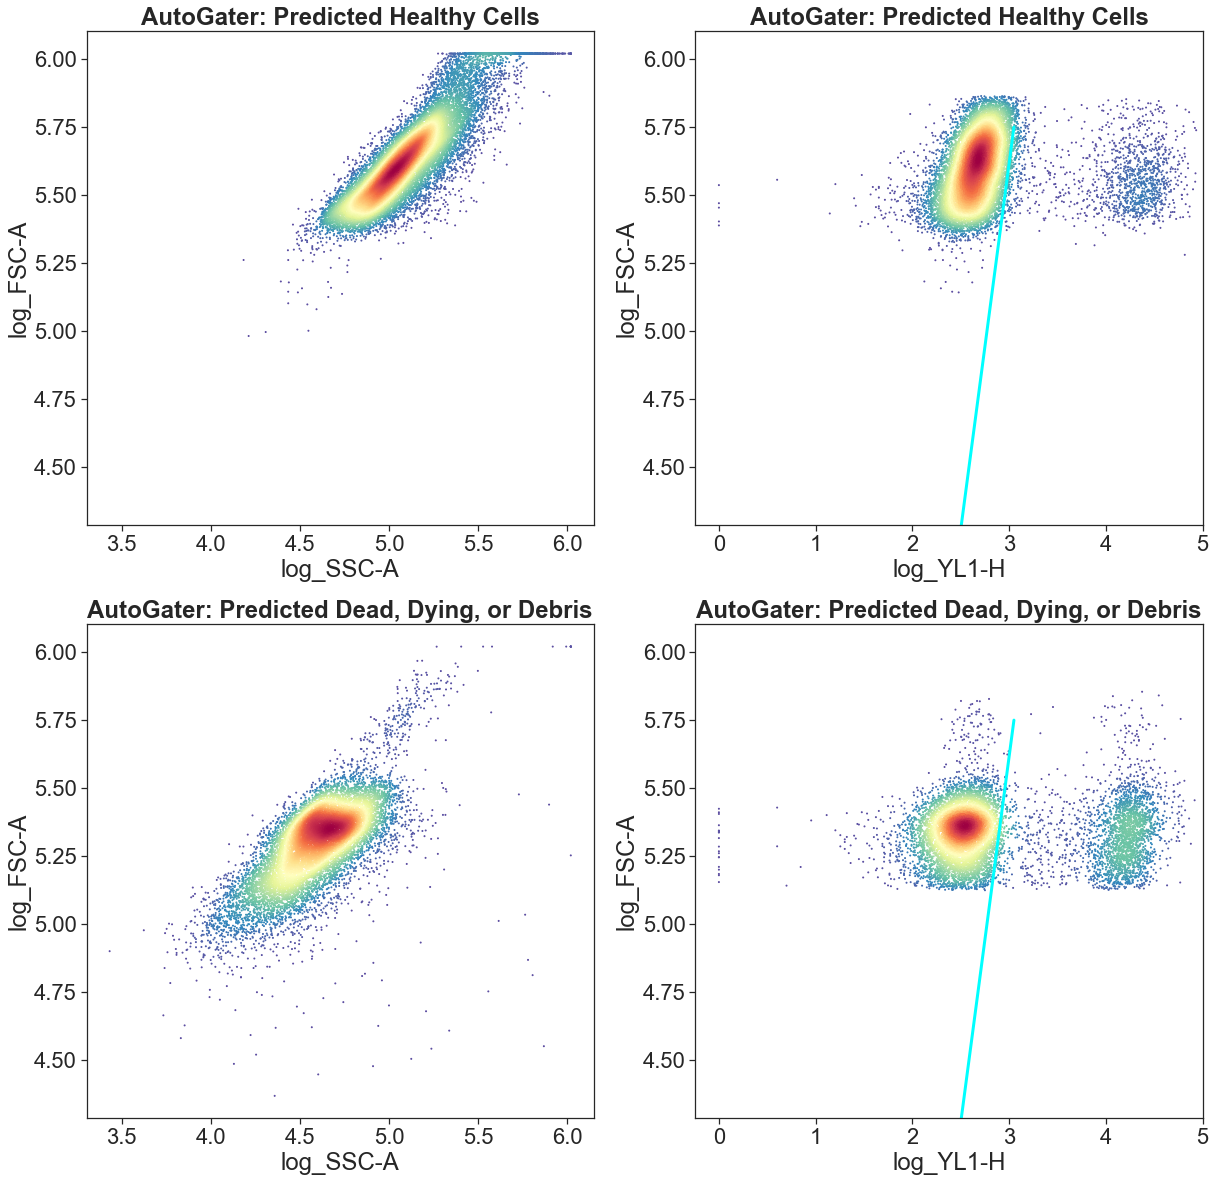

In [91]:
_, _ = kde_scatter(conc_df_all.loc[conc_df_all[n.inducer_concentration]!=80.0], logged=True, 
                   subset_ratio=0.85, cmap="Spectral_r",
                   pred_col="nn_preds", pred_display_type="scatter_density", 
                   line_params=([2.4, 3.05], [4, 5.75]))

# Calculate SOA_preds using visual line determined from above plots

In [70]:
kde_df["SOA_preds"] = 0

# get indices of points in kde_df_sub that are above the line drawn above
not_debris = kde_df_sub.loc[kde_df_sub["kmeans"] == 1]  # first need to get upper right ellipse in top-left plot
not_debris["SOA_line"] = 2.6923076923076925 * not_debris["log_YL1-H"] - 2.4615384615384617
not_debris["SOA_preds"] = (not_debris["log_FSC-A"] > not_debris["SOA_line"]).astype(int)
idxs = not_debris.loc[not_debris["SOA_preds"] == 1].index

kde_df.loc[idxs, "SOA_preds"] = 1

## Summary Table

In [71]:
summary_table = kde_df.groupby([n.inducer_concentration, n.timepoint], as_index=False).mean()

name_weakly = "Weakly Supervised Model (RF)"
name_cfu = "CFUs"
name_weakly_boosted = "AutoGater"
name_SOA = "State of the Art"

summary_table.rename(columns={"label": name_weakly, 
                              "cfu_percent_live": name_cfu,
                              "nn_preds": name_weakly_boosted,
                              "SOA_preds": name_SOA}, inplace=True)

summary_table = summary_table[[n.inducer_concentration, n.timepoint, 
                               name_weakly, name_cfu, name_weakly_boosted, name_SOA]]
summary_table = summary_table.loc[summary_table[n.timepoint].isin([0.5, 3.0, 6.0])]
summary_table[name_weakly] = (summary_table[name_weakly]*100).astype(int).astype(str) + "%"
summary_table[name_cfu] = summary_table[name_cfu].astype(int).astype(str) + "%"
summary_table[name_weakly_boosted] = (summary_table[name_weakly_boosted]*100).astype(int).astype(str) + "%"
summary_table[name_SOA] = (summary_table[name_SOA]*100).astype(int).astype(str) + "%"

summary_table[n.inducer_concentration] = summary_table[n.inducer_concentration].astype(str)
summary_table[n.timepoint] = summary_table[n.timepoint].astype(str)
# summary_table.to_csv("summary_table.csv", index=False)

summary_table_styled = summary_table.style.set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
summary_table_styled.set_properties(**{'text-align': 'center'}).hide_index()

summary_table_styled

inducer_concentration,timepoint,Weakly Supervised Model (RF),CFUs,AutoGater,State of the Art
0.0,0.5,94%,100%,57%,98%
0.0,3.0,98%,94%,66%,98%
0.0,6.0,99%,94%,70%,98%
5.0,0.5,93%,73%,69%,94%
5.0,3.0,95%,73%,82%,94%
5.0,6.0,95%,63%,77%,97%
10.0,0.5,92%,80%,63%,93%
10.0,3.0,90%,54%,60%,91%
10.0,6.0,90%,42%,61%,90%
15.0,0.5,82%,33%,52%,75%


In [72]:
summary_table

,inducer_concentration,timepoint,Weakly Supervised Model (RF),CFUs,AutoGater,State of the Art
1,0.0,0.5,94%,100%,57%,98%
2,0.0,3.0,98%,94%,66%,98%
3,0.0,6.0,99%,94%,70%,98%
5,5.0,0.5,93%,73%,69%,94%
6,5.0,3.0,95%,73%,82%,94%
7,5.0,6.0,95%,63%,77%,97%
9,10.0,0.5,92%,80%,63%,93%
10,10.0,3.0,90%,54%,60%,91%
11,10.0,6.0,90%,42%,61%,90%
13,15.0,0.5,82%,33%,52%,75%


In [73]:
concat_summary_table = pd.concat([summary_table[["inducer_concentration",
                                                 "timepoint", "CFUs"]].assign(model='CFUs'), 
                                  summary_table[["inducer_concentration",
                                                 "timepoint", "AutoGater"]].assign(model='AutoGater'),
                                  summary_table[["inducer_concentration",
                                                 "timepoint", "State of the Art"]].assign(model='State of the Art')])
concat_summary_table.rename(columns={"CFUs": "percent"}, inplace=True)

concat_summary_table['percent'].update(concat_summary_table.pop('AutoGater'))
concat_summary_table['percent'].update(concat_summary_table.pop('State of the Art'))
concat_summary_table["timepoint"] = concat_summary_table["timepoint"].astype(float)
concat_summary_table["percent"] = concat_summary_table["percent"].str.rstrip('%').astype('float')

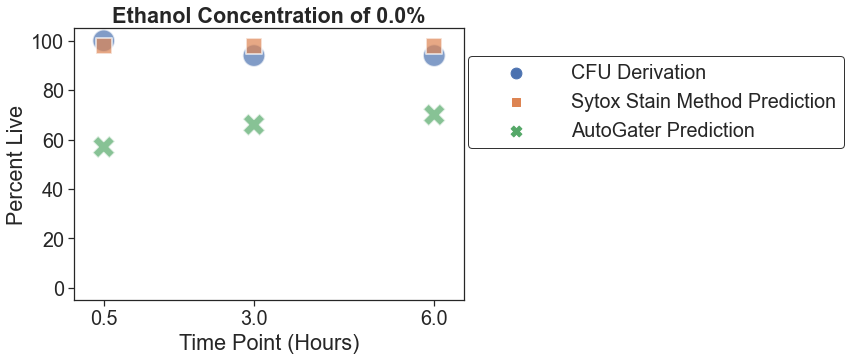

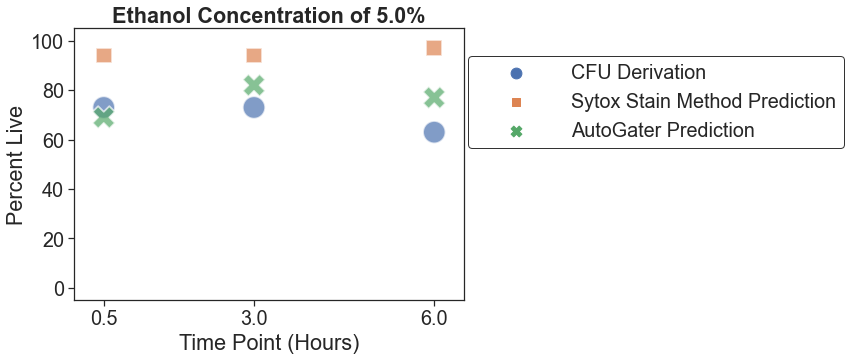

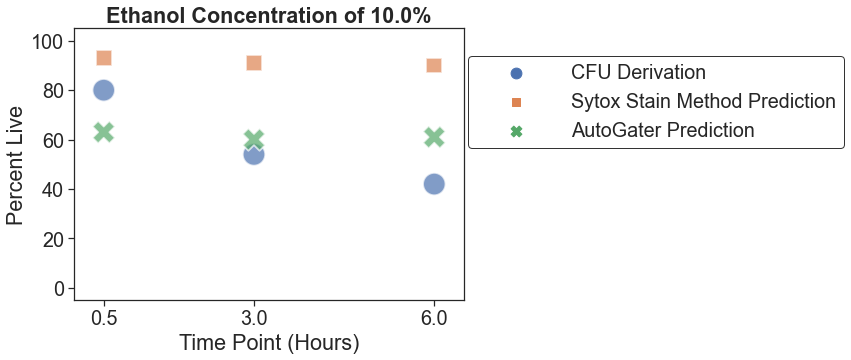

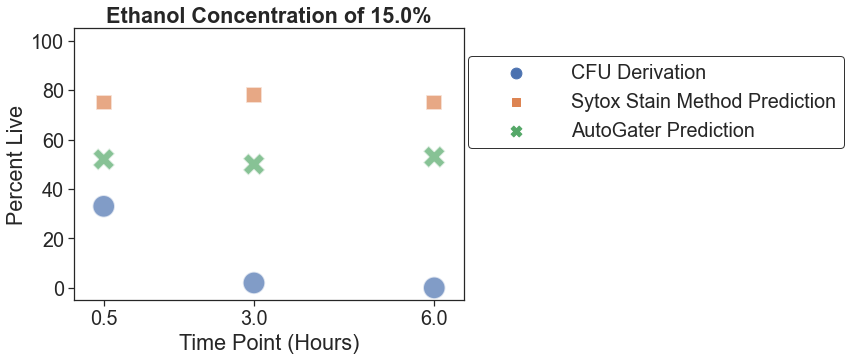

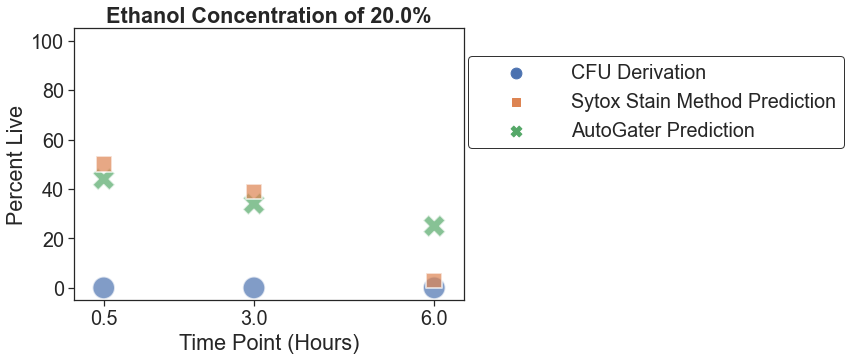

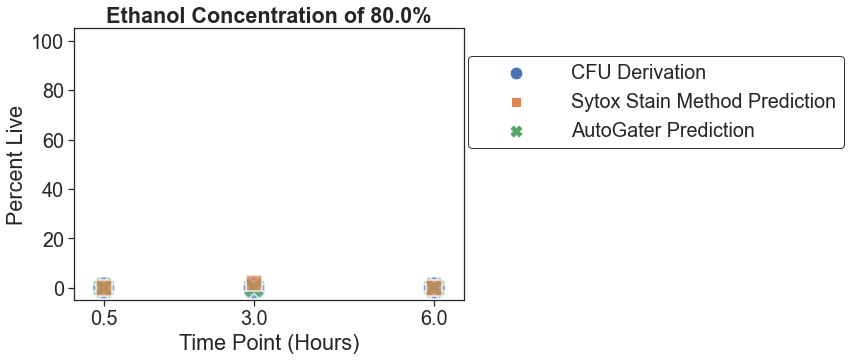

In [92]:
sns.set(style="ticks", font_scale=1.8, rc={"lines.linewidth": 3.0})

for c in [str(x) for x in list(concat_summary_table[n.inducer_concentration].unique())]:
    plt.figure(figsize=(7, 5))

    sc = sns.scatterplot(data=concat_summary_table.loc[concat_summary_table["inducer_concentration"] == c], 
                         x="timepoint", y="percent", s=500, alpha=.7, style="model",
                         hue="model", hue_order=["CFUs", "State of the Art", "AutoGater"], legend="full")

    legend = plt.legend(bbox_to_anchor=(1.01, 0.9), loc=2, borderaxespad=0.,
                        handlelength=4, markerscale=1.8)
    legend.get_frame().set_edgecolor('black')
    new_labels = ['CFU Derivation', 'Sytox Stain Method Prediction', 'AutoGater Prediction']
    for t, l in zip(legend.texts, new_labels): t.set_text(l)

    sc.set(xlim=(0, 6.5), xlabel="Time Point (Hours)",
           ylim=(-5, 105), ylabel="Percent Live",
           xticks=[0.5, 3, 6])
    sc.set_title("Ethanol Concentration of {}%".format(c), fontweight="bold")
    plt.show()